# Naive Bayes Classification

## Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Evaluation Metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [2]:
train_data = pd.read_excel('./Data_Naive_Bayes.xlsx', sheet_name='Train')
test_data = pd.read_excel('./Data_Naive_Bayes.xlsx', sheet_name='Test')

In [3]:
train_data.head()

,gmat,gpa,work_experience,admitted
0,780,4.0,3,1
1,750,3.9,4,1
2,690,3.3,3,0
3,710,3.7,5,1
4,680,3.9,4,0


In [4]:
test_data

,gmat,gpa,work_experience
0,590,2.0,3
1,740,3.7,4
2,680,3.3,6
3,610,2.3,1
4,710,3.0,5


## Exploring Data
- Data tersebut memiliki 3 feature (gmat, gpa, work_experience) dan 1 target variable yaitu (admitted). Sekarang kita coba melihat terlebih dahulu data yang ada.

### Visualizing Dataset

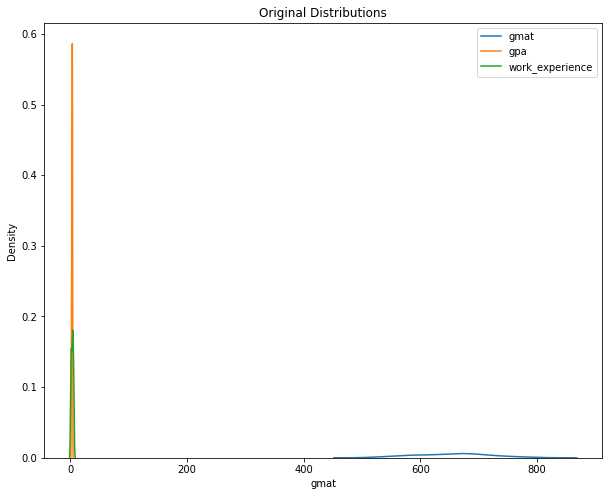

In [5]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10,8))
ax1.set_title('Original Distributions')

features = ['gmat', 'gpa', 'work_experience']

for f in features:
    sns.kdeplot(train_data[f], ax=ax1, label=f)

plt.legend()
plt.show()

> Dari visualisasi di atas, terlihat bahwa data tersebut belum ternomalisasi dengan baik, terlihat bahwa skala angka di variable 'gmat' sangat berbeda jauh dengan skala angka di variable 'gpa' dan 'work_experience', sehingga perlu dilakukan normalisasi.

### Checking Correlation

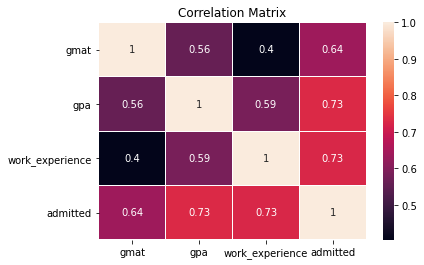

In [6]:
plt.title('Correlation Matrix')
sns.heatmap(data=train_data.corr() , annot=True, linewidth=0.1)
plt.show()

> Dari sini bisa dilihat bahwa korelasi tiap features terhadap target variable adalah korelasi yang kuat (> 0.5), sehingga tidak perlu melakukan penghapusan kolom. Selain itu, tidak ditemukan juga Multicolinear, sehingga data ini sudah cukup baik.

## Preprocessing Data

### Splitting Data

In [7]:
features = ['gmat', 'gpa', 'work_experience']
target = ['admitted']
X = train_data[features]
y = train_data[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

> Stratifying the data to make sure that each training and validation data have the same amount ratio of class 1 and 0

In [8]:
print(f'Train Data: {X_train.shape}')
print(f'Validation Data: {X_valid.shape}')

Train Data: (30, 3)
Validation Data: (10, 3)


### Normalizing the Data

In [9]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns, index=X_valid.index)

#### Comparing Before and After Normalization

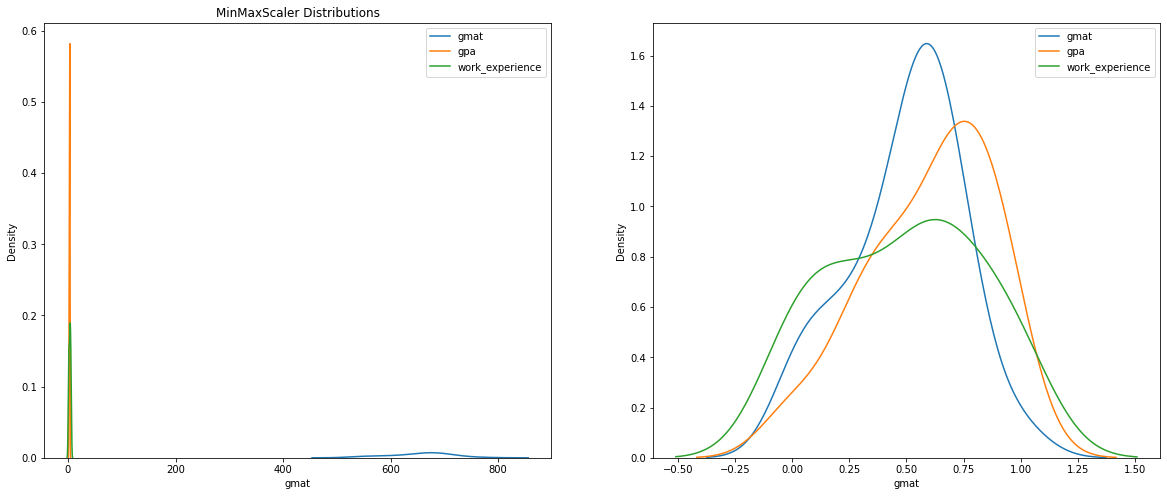

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,8))
ax1.set_title('Original Distributions')

for f in features:
    sns.kdeplot(X_train[f], ax=ax1, label=f)
ax1.legend()

ax1.set_title('MinMaxScaler Distributions')

for f in features:
    sns.kdeplot(X_train_scaled[f], ax=ax2, label=f)
ax2.legend()

plt.show()

> Kedua visualisasi ini membandingkan data yang sebelum dinormalisasi dan setelah dinormalisasi, terlihat bahwa data yang telah dinormalisasi sudah baik.

## Modelling using Naive Bayes

In [29]:
class Naive_Bayes:

    def fit(self, X, y):
        self.parameters = {}
        self.priors = {}

        for i in X.columns:
            self.parameters[i] = {}
        
        full_df = pd.concat([X, y], axis=1)
        full_df = full_df.sort_values(by=['admitted'])
        self.unique_class = y['admitted'].unique()

        # Dividing class 1 and 0
        divide_class = {}
        for x in self.unique_class:
            divide_class[x] = full_df[full_df['admitted'] == x].loc[:, full_df.columns != 'admitted']

        # Finding Mean and Variance
        for i in divide_class:
            for j in divide_class[i]:
                self.parameters[j][i] = self.mean_variance(divide_class[i][j])
        
        # Calculate prior probability each class
        for i in self.unique_class:
            self.priors[i] = len(divide_class[i])/ len(full_df)
    
    def mean_variance(self, df):
        mean = df.mean()
        variance = df.var()
        return {'mean': mean, 'variance': variance}

    def predict(self, X):
        predictions = []

        for i in range(len(X)):
            full_class_posterior = np.array([])

            for x in self.unique_class:
                posterior_likelihood = 1

                for cols in X.columns:
                    value = X.iloc[i][cols]
                    mean = self.parameters[cols][x]['mean']
                    variance = self.parameters[cols][x]['variance']
                    likelihood = (1 / (np.sqrt(2 * np.pi * variance))) * np.exp(-1 * ((value - mean)**2 / (2 * variance)))
                    posterior_likelihood *= likelihood

                post = posterior_likelihood * self.priors[x]
                full_class_posterior = np.append(full_class_posterior, post)
            predictions.append(self.unique_class[np.argmax(full_class_posterior)])
        return predictions

In [30]:
model = Naive_Bayes()
model.fit(X_train_scaled, y_train)

## Prediction

### Predict using Validation Data

In [32]:
y_valid_pred = model.predict(X_valid_scaled)
y_valid_pred

[0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

## Evaluation

- Evaluate the model by comparing between ground truth and prediction on Validation Data

In [33]:
df_valid = pd.DataFrame({
    'GROUND TRUTH': y_valid['admitted'],
    'PREDICTIONS': y_valid_pred
})

df_valid

,GROUND TRUTH,PREDICTIONS
15,0,0
27,0,0
25,1,1
16,0,0
17,1,1
37,0,0
8,1,1
0,1,1
1,1,1
21,0,0


> Dengan melihat tabel, bisa dilihat bahwa model Naive Bayes ini bisa mengklasifikasikan dengan baik antara 1 dan 0, dan hasilnya sesuai dengan ground truth.

#### Confusion Matrix

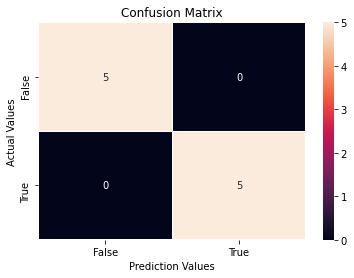

In [34]:
cf = confusion_matrix(y_valid['admitted'], y_valid_pred)
ax = sns.heatmap(cf, annot=True, linewidth=0.1)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### Evaluation Score

In [35]:
TRUTH_VALUE = y_valid['admitted']
print(f'Accuracy Score: {accuracy_score(TRUTH_VALUE, y_valid_pred)}')
print(f'Precision Score: {precision_score(TRUTH_VALUE, y_valid_pred)}')
print(f'Recall Score: {recall_score(TRUTH_VALUE, y_valid_pred)}')
print(f'F1 Score: {f1_score(TRUTH_VALUE, y_valid_pred)}')
print(f'\nClassification Score:\n {classification_report(TRUTH_VALUE, y_valid_pred)}')

Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1 Score: 1.0

Classification Score:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



> Dari hasil evaluasi model, baik score precision, recall, dan f1-score, terbukti bahwa model ini sangat baik (bekerja hingga 100%).

## Using Model on Test Data

In [36]:
test_data

,gmat,gpa,work_experience
0,590,2.0,3
1,740,3.7,4
2,680,3.3,6
3,610,2.3,1
4,710,3.0,5


In [37]:
# Normalize Data
X_test_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Prediction
PREDICTION = model.predict(X_test_scaled)
PREDICTION

[0, 1, 1, 0, 1]

### Final Answer on 'Admitted' Column on Test Data

In [38]:
Data_Test = pd.concat([test_data, pd.Series(PREDICTION, name='admitted')],axis=1)
Data_Test

,gmat,gpa,work_experience,admitted
0,590,2.0,3,0
1,740,3.7,4,1
2,680,3.3,6,1
3,610,2.3,1,0
4,710,3.0,5,1


In [39]:
Data_Test_Scaled = pd.concat([X_test_scaled, pd.Series(PREDICTION, name='admitted')],axis=1)
Data_Test_Scaled

,gmat,gpa,work_experience,admitted
0,0.217391,0.130435,0.4,0
1,0.869565,0.869565,0.6,1
2,0.608696,0.695652,1.0,1
3,0.304348,0.260870,0.0,0
4,0.739130,0.565217,0.8,1
